In [1]:
from collections import defaultdict
import gensim
%matplotlib inline
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import sentiwordnet as swn
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

# 乱数の固定
SEED = 0
# word2vec を学習するか
train_word2vec = False
# text の前処理をするか
text_preprocessing = True
# MIN_COUNT に到達しない単語にも情報があれば付与したり，UNDEFINED などにしたほうが後々楽
MIN_COUNT = 10
debug = True
input_dir = os.path.join("..", "input")
jigsaw_path = "jigsaw-unintended-bias-in-toxicity-classification"

In [2]:
train_df = pd.read_csv(os.path.join(input_dir, jigsaw_path, "train.csv"))
if debug:
    print("train columns", train_df.columns)
    print("train shape", train_df.shape)
train_df.head()

train columns Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')
train shape (1804874, 45)


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [3]:
test_df = pd.read_csv(os.path.join(input_dir, jigsaw_path, "test.csv"))
if debug:
    print("test columns", test_df.columns)
    print("test shape", test_df.shape)
test_df.head()

test columns Index(['id', 'comment_text'], dtype='object')
test shape (97320, 2)


,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


In [4]:
all_document = train_df["comment_text"].tolist() + test_df["comment_text"].tolist()

In [5]:
target = train_df["target"].tolist()

# 評価の分布と評価の分布に対する近似線

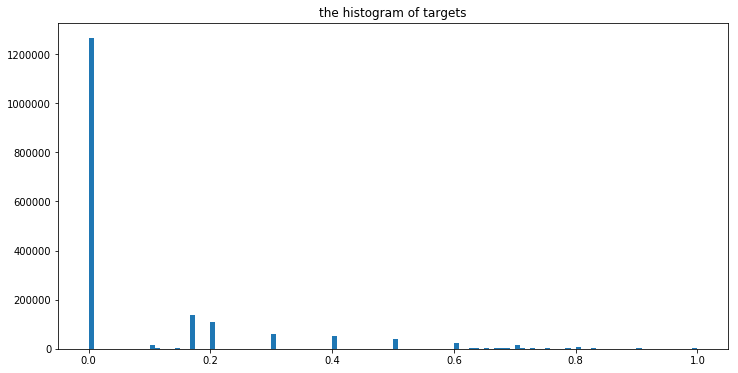

In [6]:
# 評価の分布
plt.figure(figsize=(12,6))
info = plt.hist(target, bins=120)
plt.title("the histogram of targets")
plt.show()

In [7]:
target_score = info[0].astype(int)
# どうやら，3分の2が 0 の模様
pd.DataFrame(data=[[target_score[0], sum(target_score[1:])]], columns=["score 0", "others"])

,score 0,others
0,1265039,539835


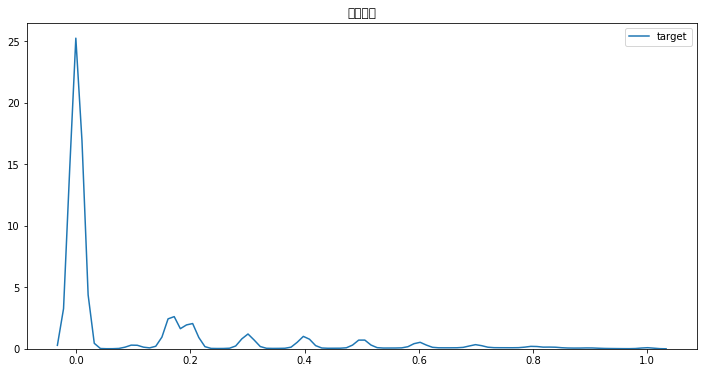

In [8]:
plt.figure(figsize=(12,6))
plt.title("近似直線")
sns.distplot(target,kde=True,hist=False, bins=120, label='target')
plt.legend(); plt.show()

# 評価と付けられたラベルの分布
funny wow sad likes disagree sexual_explicit の6つある

In [29]:
def get_count(feature):
    total = float(len(train_df))
    info = train_df[feature].tolist()
    div = 100//5+0.00001 # 割る値が分割数
    count_dict = {i:[0, 0] for i in range(int(div))}
    for i, t in zip(info, target):
        hist = int((t*100)//div)
        if i > 0:
            count_dict[hist][0] += 1
        count_dict[hist][1] += 1
    y = np.asarray([count_dict[i] for i in range(int(div))])
    return y.T[0]/y.T[1] 

In [30]:
features = "funny wow sad likes disagree sexual_explicit".split()
label_count = [get_count(feature) for feature in features]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


# ラベルがあるかないか
左右に向けて垂れやすい傾向が見える

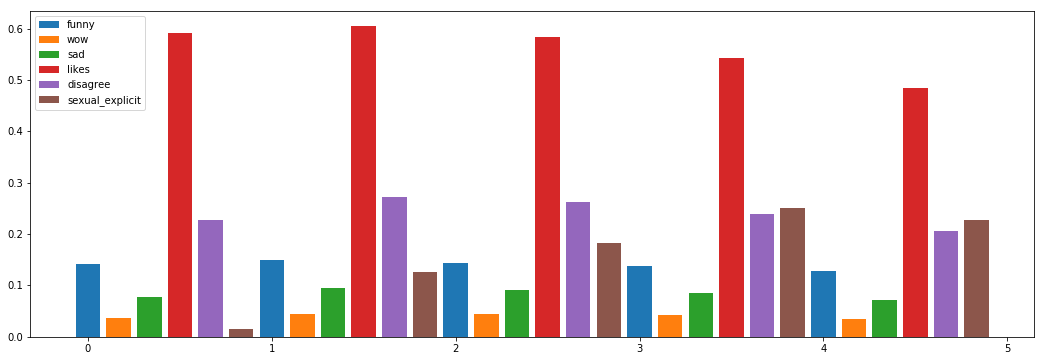

In [31]:
plt.figure(figsize=(18,6))
for i in range(len(features)):
    plt.bar(np.arange(len(label_count[i]))+i/len(features), label_count[i], width=0.8/len(features), label=features[i])
plt.legend()
plt.show()

In [32]:
def get_count(feature):
    total = float(len(train_df))
    info = train_df[feature].tolist()
    div = 100//5+0.00001 # 割る値が分割数
    count_dict = {i:[0, 0] for i in range(int(div))}
    for i, t in zip(info, target):
        hist = int((t*100)//div)
        if i > 0:
            count_dict[hist][0] += i
        count_dict[hist][1] += 1
    y = np.asarray([count_dict[i] for i in range(int(div))])
    return y.T[0]/y.T[1] 

In [33]:
features = "funny wow sad likes disagree sexual_explicit".split()
label_count = [get_count(feature) for feature in features]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


# ラベルのスコアも使用
左右に向けて垂れやすい傾向が見える

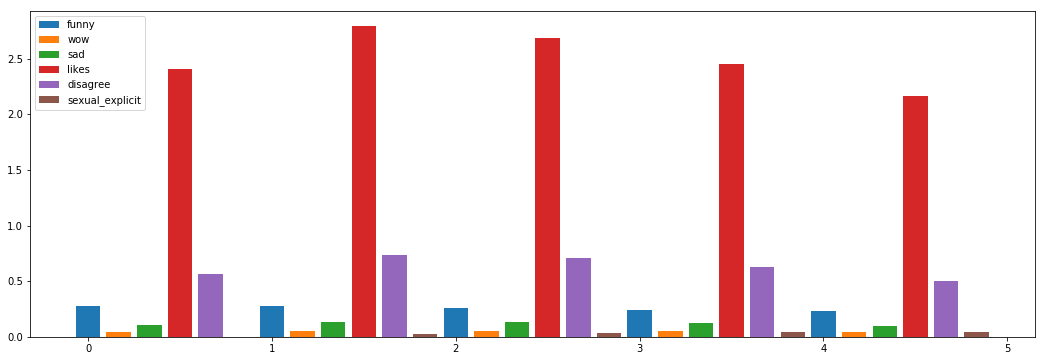

In [34]:
plt.figure(figsize=(18,6))
for i in range(len(features)):
    plt.bar(np.arange(len(label_count[i]))+i/len(features), label_count[i], width=0.8/len(features), label=features[i])
plt.legend()
plt.show()

correlation against target [-0.00740537108042009, 0.01239042623887071, 0.018012686071773674, 0.01914559497333132, 0.024574770949607885, 0.2525066343773998]


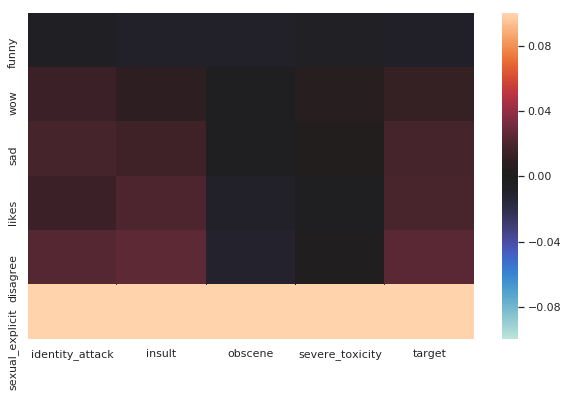

In [35]:
# 相関
columns = ('target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult')
rows = [{c:train_df[f].corr(train_df[c]) for c in columns} for f in features]
train_correlations = pd.DataFrame(rows, index=features)
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
ax = sns.heatmap(train_correlations, vmin=-0.1, vmax=0.1, center=0.0)
# target に対する相関上から順
print("correlation against target", [row["target"] for row in rows])

In [36]:
np.abs(np.asarray(train_df["target"].tolist())-0.5)

array([0.5       , 0.5       , 0.5       , ..., 0.5       , 0.12121212,
       0.5       ])

correlation against target [0.00414429657972387, -0.01663244996885638, -0.024362368160178508, -0.030989695259878058, -0.035449661415470346, -0.21719050532129086]


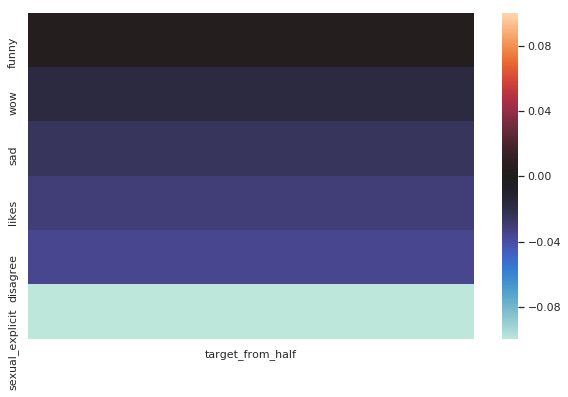

In [37]:
# 相関
# なんとなく，0.5 を基準として，絶対値で評価（target 0.5 の時 0, target 0 or 1 の時 0.5）
train_df["target_from_half"] = np.abs(np.asarray(target)-0.5)
columns = ['target_from_half']
rows = [{c:train_df[f].corr(train_df[c]) for c in columns} for f in features]
train_correlations = pd.DataFrame(rows, index=features)
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
ax = sns.heatmap(train_correlations, vmin=-0.1, vmax=0.1, center=0.0)
# target に対する相関上から順
print("correlation against target", [row["target_from_half"] for row in rows])

# 悪意を感じた属性に対するスコア
severe_toxicity	obscene	identity_attack	insult の 4つ

基本的には増加傾向．上でもそうだったが，悪意を本当に強く感じてる時だけは傾向がちょっと違うよう

In [38]:
features = "severe_toxicity obscene identity_attack insult".split()
label_count = [get_count(feature) for feature in features]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


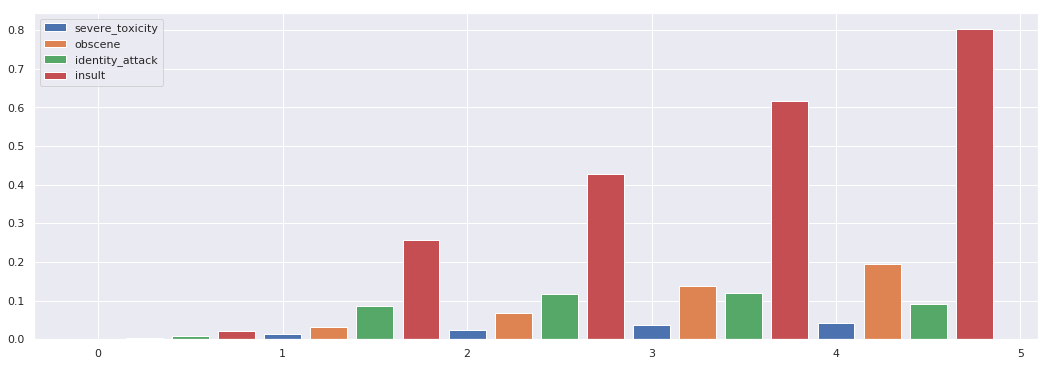

In [39]:
plt.figure(figsize=(18,6))
for i in range(len(features)):
    plt.bar(np.arange(len(label_count[i]))+i/len(features), label_count[i], width=0.8/len(features), label=features[i])
plt.legend()
plt.show()

correlation against target [0.3934254533583331, 0.49305811355108004, 0.45001663392720787, 0.9282066239222545]


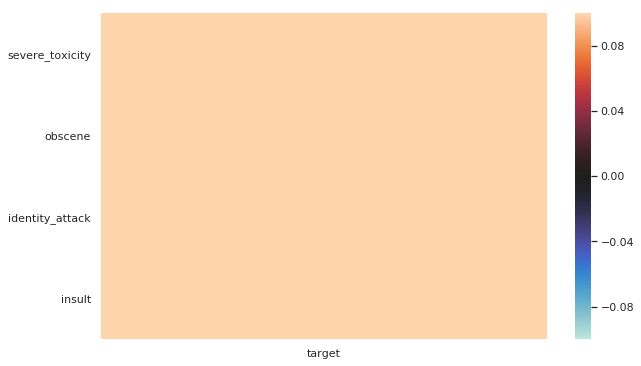

In [40]:
# 相関
# 当たり前だが，強めの相関
columns = ['target']
rows = [{c:train_df[f].corr(train_df[c]) for c in columns} for f in features]
train_correlations = pd.DataFrame(rows, index=features)
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
ax = sns.heatmap(train_correlations, vmin=-0.1, vmax=0.1, center=0.0)
# target に対する相関上から順
print("correlation against target", [row["target"] for row in rows])

# comment text の情報を評価
単語の長さや単語の種類など（拾い物）

In [41]:
train_df['total_length'] = train_df['comment_text'].apply(len)
train_df['capitals'] = train_df['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
train_df['caps_vs_length'] = train_df.apply(lambda row: float(row['capitals'])/float(row['total_length']),axis=1)
train_df['num_exclamation_marks'] = train_df['comment_text'].apply(lambda comment: comment.count('!'))
train_df['num_question_marks'] = train_df['comment_text'].apply(lambda comment: comment.count('?'))
train_df['num_punctuation'] = train_df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
train_df['num_symbols'] = train_df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
train_df['num_words'] = train_df['comment_text'].apply(lambda comment: len(comment.split()))
train_df['num_unique_words'] = train_df['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))
train_df['words_vs_unique'] = train_df['num_unique_words'] / train_df['num_words']
train_df['num_smilies'] = train_df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))

In [42]:
features = ('total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks','num_question_marks', 'num_punctuation', 'num_words', 'num_unique_words','words_vs_unique', 'num_smilies', 'num_symbols')
columns = ('target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'funny', 'wow', 'sad', 'likes', 'disagree', 'sexual_explicit','identity_annotator_count', 'toxicity_annotator_count')
rows = [{c:train_df[f].corr(train_df[c]) for c in columns} for f in features]
train_correlations = pd.DataFrame(rows, index=features)

In [43]:
train_correlations

,disagree,funny,identity_annotator_count,identity_attack,insult,likes,obscene,sad,severe_toxicity,sexual_explicit,target,threat,toxicity_annotator_count,wow
total_length,0.017617,-0.084710,0.020840,0.053430,0.009085,0.060639,0.009823,-0.019940,0.007962,0.019882,0.006444,-0.013198,-0.030894,0.002572
capitals,0.003928,-0.039221,0.012405,0.050489,0.026358,0.018707,0.027995,-0.005448,0.025127,0.014144,0.026120,0.000721,-0.009082,0.009687
caps_vs_length,-0.021716,0.021263,-0.005510,-0.008477,-0.006029,-0.038470,0.017088,0.002848,0.010594,-0.003575,-0.005344,0.000822,0.015381,-0.000603
num_exclamation_marks,-0.009384,0.007073,0.000869,0.017085,0.052533,-0.007866,0.056108,0.005158,0.035388,0.019437,0.055152,0.021267,0.024115,0.002225
num_question_marks,-0.002180,-0.009290,0.006305,0.028554,0.014366,-0.002731,0.019233,0.002023,0.011662,0.015987,0.019308,-0.000430,-0.003307,0.001263
num_punctuation,0.001415,-0.057187,0.018050,0.042990,0.018911,0.029581,0.017701,-0.016511,0.013266,0.018985,0.016974,-0.006479,-0.021231,0.001959
num_words,0.016121,-0.084398,0.020595,0.050527,0.011975,0.059481,0.014536,-0.019412,0.009696,0.021525,0.009579,-0.009893,-0.029856,0.002714
num_unique_words,0.019634,-0.085764,0.020787,0.053659,0.019494,0.063874,0.017918,-0.018110,0.011900,0.022816,0.016702,-0.008946,-0.029814,0.003490
words_vs_unique,-0.020712,0.079045,-0.019749,-0.048941,0.001135,-0.060162,-0.003007,0.016223,-0.005329,-0.015748,0.001172,0.009367,0.027853,-0.004150
num_smilies,-0.010936,0.010109,-0.000576,-0.008337,-0.009401,-0.016607,-0.001024,-0.002133,-0.003877,-0.000414,-0.010040,-0.003190,-0.003030,-0.002777


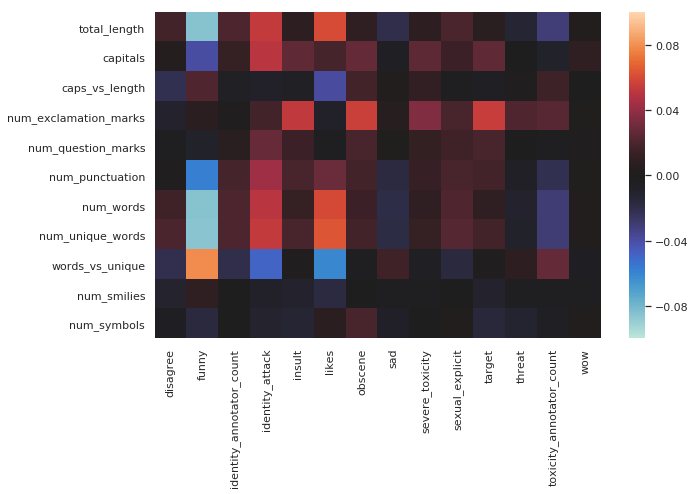

In [44]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
ax = sns.heatmap(train_correlations, vmin=-0.1, vmax=0.1, center=0.0)

# 連続する文字列の長さを見る

In [45]:
continue_chars = [] # FUUUUUUU や !!!!!!!!
continue_bichars = [] #hahahaha など
for comment in train_df["comment_text"]:
    max_count = 0
    count = 0
    prev = ""
    for i in comment:
        if prev != i:
            count = 0
        else:
            count += 1
        prev = i
        max_count = max(max_count, count)
    continue_chars.append(max_count)
    
    max_count = 0
    count = 0
    prev = ""
    for i in comment[::2]:
        if prev != i:
            count = 0
        else:
            count += 1
        prev = i
        max_count = max(max_count, count)
    continue_bichars.append(max_count)

In [46]:
train_df["continue_chars"] = continue_chars
train_df["continue_bichars"] = continue_bichars

In [47]:
# そのままだと，1や2が多すぎる
train_df["continue_chars_over5"] = [1 if i >= 5 else 0 for i in continue_chars]
train_df["continue_bichars_over5"] = [1 if i >= 5 else 0 for i in continue_bichars]

In [48]:
features = ["continue_chars", "continue_bichars", "continue_chars_over5", "continue_bichars_over5"]
label_count = [get_count(feature) for feature in features]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


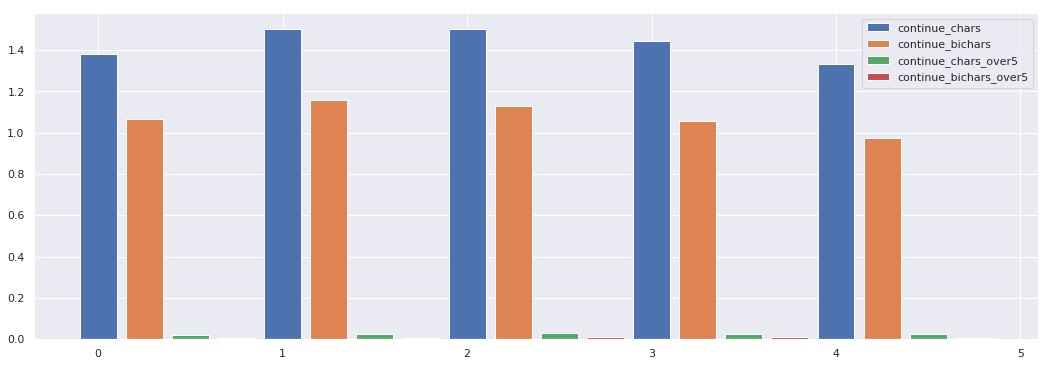

In [49]:
plt.figure(figsize=(18,6))
for i in range(len(features)):
    plt.bar(np.arange(len(label_count[i]))+i/len(features), label_count[i], width=0.8/len(features), label=features[i])
plt.legend()
plt.show()

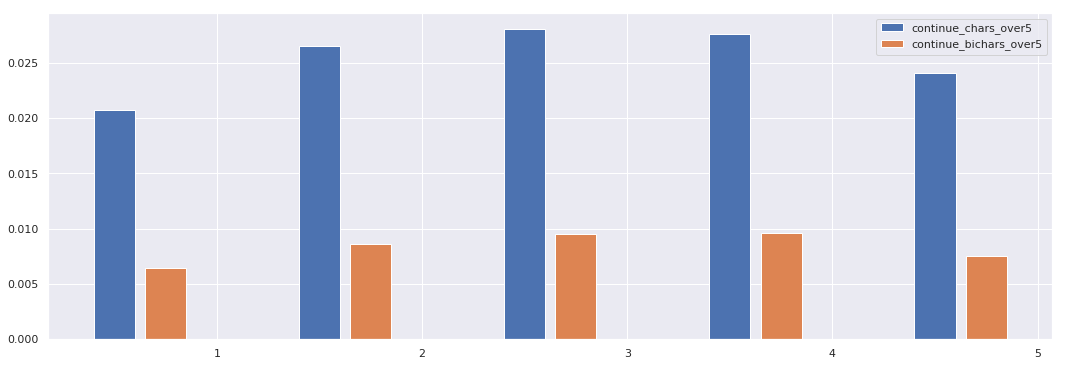

In [50]:
plt.figure(figsize=(18,6))
for i in range(len(features)):
    if i < 2:
        continue
    plt.bar(np.arange(len(label_count[i]))+i/len(features), label_count[i], width=0.8/len(features), label=features[i])
plt.legend()
plt.show()

correlation against target [0.013007758259147033, 0.012041953702374495, 0.015864313513445187, 0.01090450283981294]


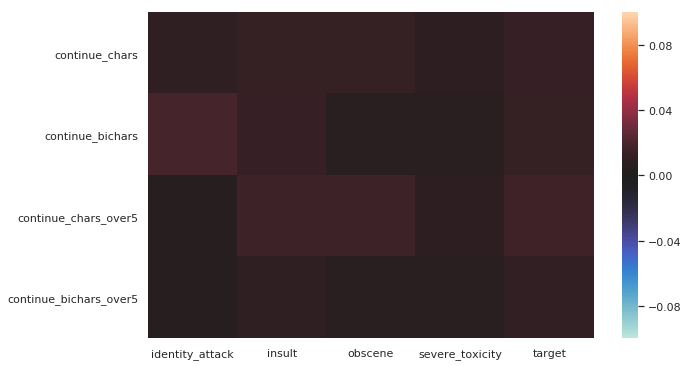

In [51]:
# 相関
columns = ('target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult')
rows = [{c:train_df[f].corr(train_df[c]) for c in columns} for f in features]
train_correlations = pd.DataFrame(rows, index=features)
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
ax = sns.heatmap(train_correlations, vmin=-0.1, vmax=0.1, center=0.0)
# target に対する相関上から順
print("correlation against target", [row["target"] for row in rows])

# ネットスラングの頻度
見る予定

# 単語の分布？

# 感情辞書からスコアを算出

In [52]:
all_senti = swn.all_senti_synsets()

In [53]:
word_count = dict()
senti_dict = dict()
for senti in all_senti:
    name = senti.synset.name().split(".")[0]
    if name not in senti_dict:
        senti_dict[name] = np.asarray([senti.pos_score(), senti.neg_score(), senti.obj_score()])
    else:
        senti_dict[name] += np.asarray([senti.pos_score(), senti.neg_score(), senti.obj_score()])
    if name not in word_count:
        word_count[name] = 1
    else:
        word_count[name] += 1

In [54]:
# 2回以上ある単語もあるので平均を計算
senti_dict = {key:np.asarray(value)/word_count[key] for key, value in senti_dict.items()}

In [55]:
senti_dict

{'able': array([0.15625, 0.     , 0.84375]),
 'unable': array([0.    , 0.5625, 0.4375]),
 'abaxial': array([0., 0., 1.]),
 'adaxial': array([0., 0., 1.]),
 'acroscopic': array([0., 0., 1.]),
 'basiscopic': array([0., 0., 1.]),
 'abducent': array([0., 0., 1.]),
 'adducent': array([0., 0., 1.]),
 'nascent': array([0., 0., 1.]),
 'emergent': array([0.0625, 0.125 , 0.8125]),
 'dissilient': array([0.25, 0.  , 0.75]),
 'parturient': array([0.125, 0.   , 0.875]),
 'dying': array([0., 0., 1.]),
 'moribund': array([0., 0., 1.]),
 'last': array([0.07142857, 0.08928571, 0.83928571]),
 'abridged': array([0., 0., 1.]),
 'cut': array([0.01851852, 0.00925926, 0.97222222]),
 'half-length': array([0.125, 0.   , 0.875]),
 'potted': array([0., 0., 1.]),
 'unabridged': array([0., 0., 1.]),
 'full-length': array([0.375, 0.   , 0.625]),
 'absolute': array([0.25  , 0.3125, 0.4375]),
 'direct': array([0.06730769, 0.01923077, 0.91346154]),
 'implicit': array([0.4375, 0.25  , 0.3125]),
 'infinite': array([0.083

# 訓練データを評価

In [88]:
all_score = []
for comment in train_df["comment_text"]:
    score = []
    for word in comment.split():
        if word in senti_dict:
            score.append([senti_dict[word]])
    if len(score) != 0:
        all_score.append(np.average(score, axis=0)[0])
    else:
        all_score.append(np.asarray([0]*3))

In [89]:
all_score = np.asarray(all_score)

In [90]:
train_df["pos_score"] = all_score.T[0]
train_df["neg_score"] = all_score.T[1]
train_df["obj_score"] = all_score.T[2]

In [91]:
features = ["pos_score", "neg_score", "obj_score"]
label_count = [get_count(feature) for feature in features]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


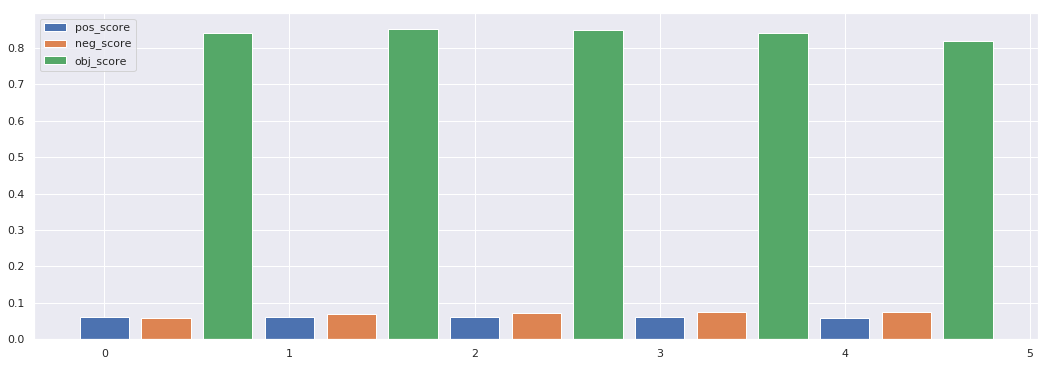

In [92]:
plt.figure(figsize=(18,6))
for i in range(len(features)):
    plt.bar(np.arange(len(label_count[i]))+i/len(features), label_count[i], width=0.8/len(features), label=features[i])
plt.legend()
plt.show()

correlation against target [0.005351563032620012, 0.08560934202600638, 0.01733669894378009]


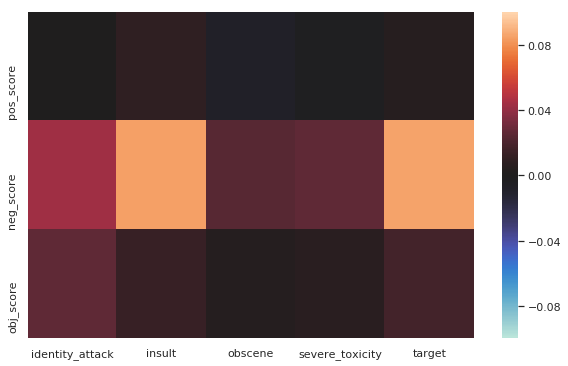

In [93]:
# 相関
# neg score はそれなりに相関がある様子
columns = ('target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult')
rows = [{c:train_df[f].corr(train_df[c]) for c in columns} for f in features]
train_correlations = pd.DataFrame(rows, index=features)
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
ax = sns.heatmap(train_correlations, vmin=-0.1, vmax=0.1, center=0.0)
# target に対する相関上から順
print("correlation against target", [row["target"] for row in rows])

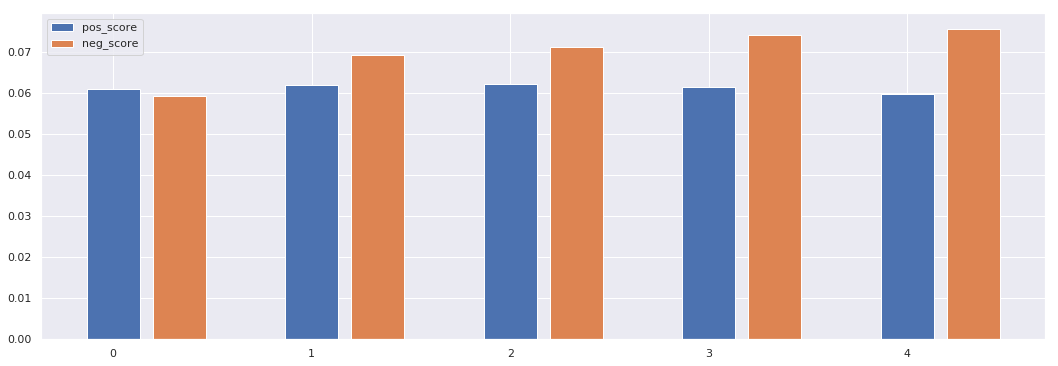

In [94]:
# pos と neg だけ表示
plt.figure(figsize=(18,6))
for i in range(len(features)):
    if i<=1:
        plt.bar(np.arange(len(label_count[i]))+i/len(features), label_count[i], width=0.8/len(features), label=features[i])
plt.legend()
plt.show()

In [95]:
np.average(all_score.T, axis=1)

array([0.06098862, 0.06108738, 0.84029256])

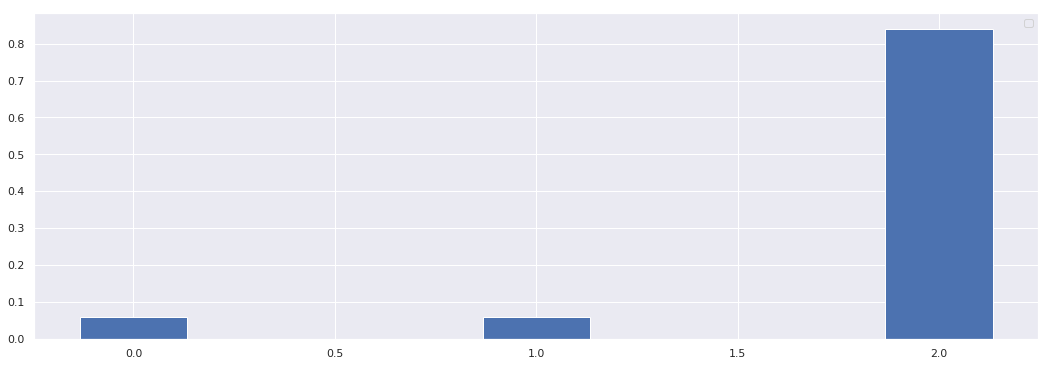

In [96]:
plt.figure(figsize=(18,6))
# pos neg obj の順
plt.bar(np.arange(3), np.average(all_score.T, axis=1), width=0.8/len(features))
plt.legend()
plt.show()

# テストデータを評価

In [97]:
all_score = []
for comment in test_df["comment_text"]:
    score = []
    for word in comment.split():
        if word in senti_dict:
            score.append([senti_dict[word]])
    if len(score) != 0:
        all_score.append(np.average(score, axis=0)[0])
    else:
        all_score.append(np.asarray([0]*3))
all_score = np.asarray(all_score)

In [98]:
test_df["pos_score"] = all_score.T[0]
test_df["neg_score"] = all_score.T[1]
test_df["obj_score"] = all_score.T[2]

## 感情辞書的には訓練とテストであまり差がない様
もう少ししっかり訓練とテスト間を見ても良いかもだが

In [99]:
np.average(all_score.T, axis=1)

array([0.06101718, 0.06106921, 0.84124078])

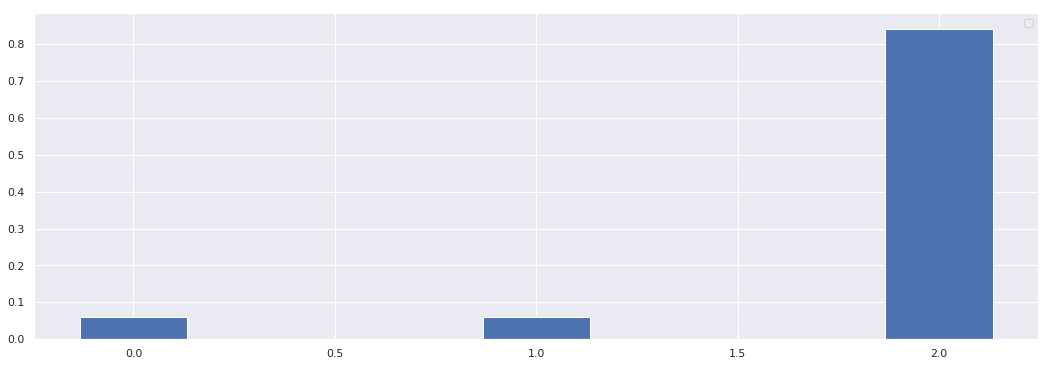

In [100]:
plt.figure(figsize=(18,6))
# pos neg obj の順
plt.bar(np.arange(3), np.average(all_score.T, axis=1), width=0.8/len(features))
plt.legend()
plt.show()